In [1]:
include("dependencies.jl")
include("brute_force_new.jl")
include("boundary_evolution.jl")
push!(LOAD_PATH, ".")
using BP, Ising2D

## Brute Force Loop

In [2]:
function get_fixed_point_list(tensors,messages,edges,links,adj_mat)
    ## get a list of the fixed point partition function at each vertex
    Z_l = []
    for index = 1:length(tensors)
        nbrs = BP.get_nbrs(adj_mat, index)
        Z_local = tensors[index] 
        for nbr in nbrs
            Z_local *= messages[nbr,index] 
        end
        @assert isempty(inds(Z_local))  "T[$index] must be a scalar"
        push!(Z_l,scalar(Z_local))
    end
    return Z_l  
end

function normalize_tensor(tensors,Z_l)
    ## normalize the tensor network by dividing by the BP fixed point
    T_copy = copy(tensors)
    for index = 1:length(tensors)
        T_copy[index] /= Z_l[index]
    end
    return T_copy
end

normalize_tensor (generic function with 1 method)

In [19]:
function BP_fixed_point_free_energy(L,β;h=0)
    N = L^2
    tensors = Ising2D.get_ising_tn(L,β;h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,BPedges,BPlinks) 
    messages = BP.message_passing(tensors,messages,BPedges,BPlinks,BPadj_mat;α=1.0,max_iters=500,diagnose=false,normalise=true)
    Z_l = get_fixed_point_list(tensors,messages,BPedges,BPlinks,BPadj_mat)
    return real(-1/2 * log.(prod(Z_l)) / N)
end

function loop_corrected_free_energy(L,β;h=0)
    N = L^2
    tensors = Ising2D.get_ising_tn(L,β;h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,BPedges,BPlinks) 
    messages = BP.message_passing(tensors,messages,BPedges,BPlinks,BPadj_mat;α=1.0,max_iters=500,diagnose=false,normalise=true)
    Z_l = get_fixed_point_list(tensors,messages,BPedges,BPlinks,BPadj_mat)
    Z_product = prod(Z_l)
    T_normalized = normalize_tensor(tensors,Z_l)
    correction_l = []

    Z = 1
    push!(correction_l, Z)
    Z += ZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)
    Z += ZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)
    Z += ZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)
    Z += ZCorrection8th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)
    Z += ZCorrection9th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)
    Z += ZCorrection10th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(correction_l, Z)

    correction_l = correction_l .* Z_product

    return real(-1/2 * log.(correction_l) / N)
end 


function log_loop_corrected_free_energy(L,β;h=0)
    N = L^2
    tensors = Ising2D.get_ising_tn(L,β;h=h)
    BPadj_mat, BPedges, BPlinks = BP.get_adj_mat(tensors)
    messages = BP.get_messages(tensors,BPedges,BPlinks) 
    messages = BP.message_passing(tensors,messages,BPedges,BPlinks,BPadj_mat;α=1.0,max_iters=500,diagnose=false,normalise=true)
    Z_l = get_fixed_point_list(tensors,messages,BPedges,BPlinks,BPadj_mat)
    Z_product = prod(Z_l)
    T_normalized = normalize_tensor(tensors,Z_l)
    log_correction_l = []
    logZ = 0
    push!(log_correction_l, logZ)
    logZ += logZCorrection4th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    logZ += logZCorrection6th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    logZ += logZCorrection7th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    logZ += logZCorrection8th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    logZ += logZCorrection9th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    logZ += logZCorrection10th(BP.loop_contribution,L,L,messages,T_normalized,BPedges,BPlinks,BPadj_mat)
    push!(log_correction_l, logZ)
    log_correction_l = log_correction_l .+ log(Z_product)

    return real(-1/2 * log_correction_l / N)
end 

log_loop_corrected_free_energy (generic function with 1 method)

4
8
12


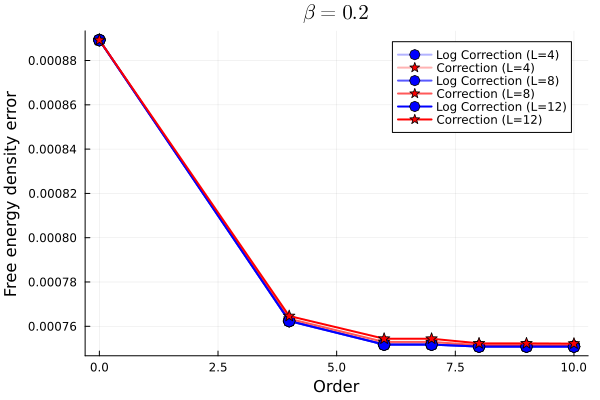

In [59]:
using Plots
using Colors  # for color conversion

L_arr = [4, 8, 12]
β = 0.2
orders = [0, 4, 6, 7, 8, 9, 10]

colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)


    y1 = log_loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)
    y2 = loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)

    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))


4
8
12


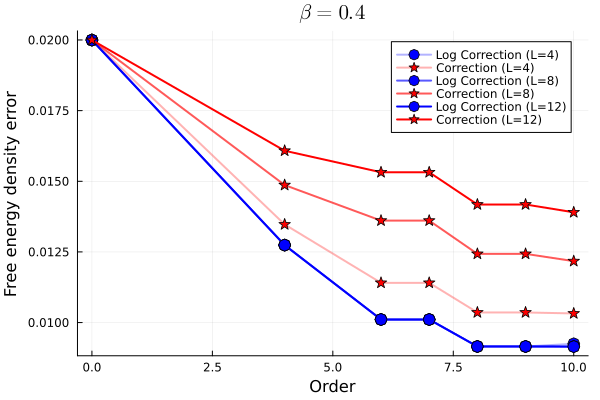

In [60]:
using Plots
using Colors  # for color conversion

L_arr = [4, 8, 12]
β = 0.4
orders = [0, 4, 6, 7, 8, 9, 10]

colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)


    y1 = log_loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)
    y2 = loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)

    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))


4
8
12


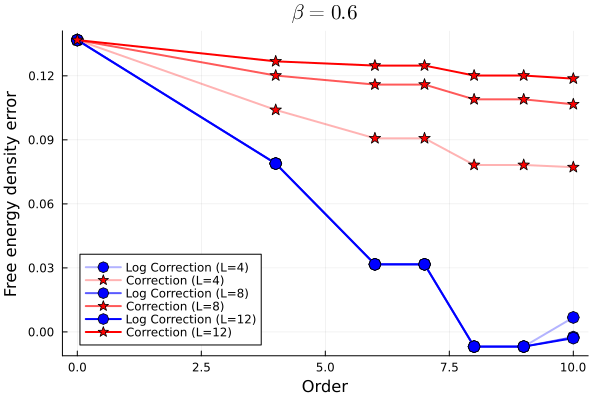

In [61]:
using Plots
using Colors  # for color conversion

L_arr = [4, 8, 12]
β = 0.6
orders = [0, 4, 6, 7, 8, 9, 10]

colors = Dict("log" => colorant"blue", "corr" => colorant"red")

plot(title = L"\beta = %$(β)",
     xlabel = "Order",
     ylabel = "Free energy density error")

for (i, L) in enumerate(L_arr)
    println(L)  
    alpha = 0.3 + 0.7 * (i - 1) / (length(L_arr) - 1)


    y1 = log_loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)
    y2 = loop_corrected_free_energy(L, β) .- Ising2D.free_energy(β)

    c1 = RGBA(colors["log"].r, colors["log"].g, colors["log"].b, alpha)
    c2 = RGBA(colors["corr"].r, colors["corr"].g, colors["corr"].b, alpha)

    plot!(orders, y1;
          label = "Log Correction (L=$L)",
          color = c1,
          linewidth = 2,
          marker = :o,
          markersize = 6)

    plot!(orders, y2;
          label = "Correction (L=$L)",
          color = c2,
          linewidth = 2,
          marker = :s,
          markersize = 6)
end

annotate!(5, 0.5 * maximum(y1), text(" ", :left, 12))


In [42]:
# scan over β values
βs = range(.01, 1., length=10)

L = 10
N = L^2
h = 0.0

# array of BP fixed point free energy
bp_fixed_point_free_energy_array = []
# array of loop corrected BP free energy
loop_corrected_free_energy_array = []
log_loop_corrected_free_energy_array = []

# array of bounary evolution free energy
boundary_evolution_free_energy_array = []
# exact free energy
exact_free_energy_array = [Ising2D.free_energy(β) for β in βs]

# time for BP fixed point
bp_fixed_point_time = []

log_loop_correction_time = []
# time for loop corrections
loop_correction_time = []
# time for boundary evolution
boundary_evolution_time = []

for β in βs
    println("Current β: ", β)
    time_start = time()
    bp_fixed_point_free_energy_array = vcat(bp_fixed_point_free_energy_array, BP_fixed_point_free_energy(L,β))
    bp_fixed_point_time = vcat(bp_fixed_point_time, time() - time_start)

    time_start = time()
    loop_corrected_free_energy_array = vcat(loop_corrected_free_energy_array, loop_corrected_free_energy(L,β)[end])
    loop_correction_time = vcat(loop_correction_time, time() - time_start)

    time_start = time()
    log_loop_corrected_free_energy_array = vcat(log_loop_corrected_free_energy_array, log_loop_corrected_free_energy(L,β)[end])
    log_loop_correction_time = vcat(loop_correction_time, time() - time_start)


    time_start = time()
    peps = generate_ising_peps(L, L, β, h)
    partition_function = contract_peps_no_phys(peps; cutoff=1E-8, maxdim=1024)
    boundary_evolution_free_energy_array = vcat(boundary_evolution_free_energy_array, (-log(partition_function)/N)/2)
    boundary_evolution_time = vcat(boundary_evolution_time, time() - time_start)
end

Current β: 0.01
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.12
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complete.
Contracting first row into boundary MPS...
Contracting bulk rows...
  Applying MPO from row 2 / 10
  Applying MPO from row 3 / 10
  Applying MPO from row 4 / 10
  Applying MPO from row 5 / 10
  Applying MPO from row 6 / 10
  Applying MPO from row 7 / 10
  Applying MPO from row 8 / 10
  Applying MPO from row 9 / 10
Contracting with final row...
Contraction finished.
Current β: 0.23
Generating Ising PEPS for a 10 x 10 lattice...
PEPS generation complet

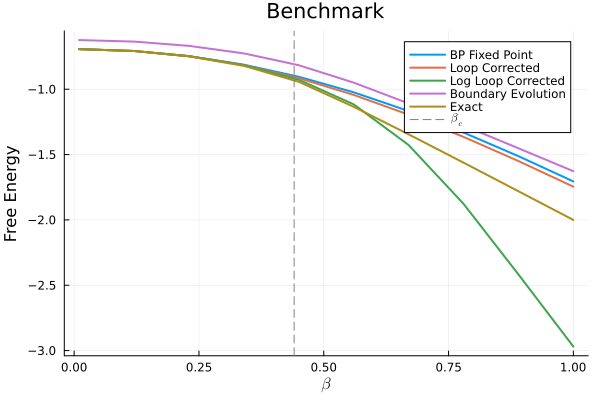

In [62]:
plot(title = "Benchmark", xlabel = L"\beta", ylabel = "Free Energy")

plot!(βs, bp_fixed_point_free_energy_array;
     label = "BP Fixed Point",
     linewidth = 2,
)

plot!(βs, loop_corrected_free_energy_array;
      label = "Loop Corrected",
      linewidth = 2,
)

plot!(βs, log_loop_corrected_free_energy_array;
      label = "Log Loop Corrected",
      linewidth = 2,
)

plot!(βs, boundary_evolution_free_energy_array;
      label = "Boundary Evolution",
      linewidth = 2,
)

plot!(βs, exact_free_energy_array;
      label = "Exact",
      linewidth = 2,
)

vline!([0.4406868], linestyle = :dash, color = :grey, label=L"\beta_c")

In [38]:
log_loop_corrected_free_energy_array

11-element Vector{Any}:
 -0.693247183894657
 -0.7076206004914029
 -0.747213344276731
 -0.8154691964753047
 -0.9156207179122269
 -1.0437490633071518
 -1.1948866177049506
 -1.3649230123161826
 -1.5498034185784806
 -1.7457500563892066
 -2.969403946560505